In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForMaskedLM, AdamW  
import torch
import torch.nn as nn
import copy

In [2]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

## Dataset

In [3]:
filenameDataset = "datasets/IMDBDatasetSPANISH.csv"
data = pd.read_csv(filenameDataset)
data.head()

,Unnamed: 0,review_en,review_es,sentiment,sentimiento
0,0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo
1,1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo
2,2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo
3,3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo
4,4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo


In [4]:
data.isnull().sum()

Unnamed: 0     0
review_en      0
review_es      0
sentiment      0
sentimiento    0
dtype: int64

In [5]:
def to_sentiment(sentiment):    
    sentiment = str(sentiment)    
    if sentiment == 'positive':
        return 1
    elif sentiment == 'negative':
        return 0
    else:
        return 2

In [6]:
#Check spanish
def selectLanguage(language, data):
    if language == "spanish":
        data['is_positive'] = data.sentiment.apply(to_sentiment)
        del data['review_en']
        del data['sentimiento']
        del data['sentiment']
        data.columns = ['id_review', 'text', 'sentiment']
    elif language == "english":
        del data['review_es']
        del data['sentimiento']
        del data[data.columns[0]]
        data.rename(columns={'review_en': 'text'}, inplace=True)
        data['sentiment'] = data.sentiment.apply(to_sentiment)
    return data

In [7]:
def basic_cleaning(text):
    text=re.sub(r'https?://www\.\S+\.com','',text)
    text=re.sub(r'[^A-Za-z|\s]','',text)
    text=re.sub(r'\*+','swear',text)
    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F" #emoticons
                               u"\U0001F300-\U0001F5FF" #symbols & pictographs
                               u"\U0001F680-\U0001F6FF" #transport & map symbols
                               u"\U0001F1E0-\U0001F1FF" #flags (iOS)
                               u"\U00002702-\U000027B0" 
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_multiplechars(text):
    text = re.sub(r'(.)\1{3,}',r'\1', text)
    return text

def clean(df):
    for col in ['text']:#,'selected_text']:
        df[col]=df[col].astype(str).apply(lambda x:basic_cleaning(x))
        df[col]=df[col].astype(str).apply(lambda x:remove_emoji(x))
        df[col]=df[col].astype(str).apply(lambda x:remove_html(x))
        df[col]=df[col].astype(str).apply(lambda x:remove_multiplechars(x))
    return df

In [8]:
idioma = "spanish"
data = selectLanguage(idioma, data)

In [9]:
data.head()

,id_review,text,sentiment
0,0,Uno de los otros críticos ha mencionado que de...,1
1,1,Una pequeña pequeña producción.La técnica de f...,1
2,2,Pensé que esta era una manera maravillosa de p...,1
3,3,"Básicamente, hay una familia donde un niño peq...",0
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",1


In [10]:
print(data.sentiment.value_counts())
print(len(data.sentiment))

1    25000
0    25000
Name: sentiment, dtype: int64
50000


In [11]:
commentDFTrain, commentDFVal = train_test_split(data, test_size=0.2, random_state=seed) 

In [12]:
commentDFTrain

,id_review,text,sentiment
18165,18165,Esta película se ha comparado con la hilarante...,0
36059,36059,Razonablemente efectivo horror / ciencia ficci...,1
13242,13242,"La inspiración para las películas ""desnudas de...",1
32985,32985,"Cuando esta película se liberó originalmente, ...",1
41133,41133,Pasé por esto por casualidad. Estaba en la cas...,1
...,...,...,...
43723,43723,Las figuras más grandes que la vida de Wyatt E...,1
32511,32511,"De acuerdo, tienes: Penelope Keith como Miss H...",0
5192,5192,Una biótica extraña y intencional de Dyan Thom...,0
12172,12172,"Estructura básica de una historia: inicio, med...",0


In [13]:
commentDFVal

,id_review,text,sentiment
26247,26247,"Sin héroes muertos, se obtienen líneas estúpid...",0
35067,35067,Pensé que tal vez ... tal vez esto podría ser ...,0
34590,34590,"Un equipo militar de élite americano que, por ...",0
16668,16668,Ridículo cine de terror sobre un hombre rico (...,0
12196,12196,"Bueno, si eres una de esas tuercas de cine de ...",1
...,...,...,...
49858,49858,Me gustó esta película.Eso es casi todo lo que...,1
19849,19849,"Imagina la difícil situación de Richard, un pi...",1
46899,46899,Hay un problema inherente al comentar o revisa...,0
28256,28256,Cuando la matriz apareció en 1999 y cuestionó ...,1


In [14]:
commentDFTrain_clean = clean(commentDFTrain)
commentDFVal_clean = clean(commentDFVal)

In [15]:
commentDFTrain_clean

,id_review,text,sentiment
18165,18165,Esta pelcula se ha comparado con la hilarante ...,0
36059,36059,Razonablemente efectivo horror ciencia ficcin...,1
13242,13242,La inspiracin para las pelculas desnudas de la...,1
32985,32985,Cuando esta pelcula se liber originalmente se ...,1
41133,41133,Pas por esto por casualidad Estaba en la casa ...,1
...,...,...,...
43723,43723,Las figuras ms grandes que la vida de Wyatt Ea...,1
32511,32511,De acuerdo tienes Penelope Keith como Miss Her...,0
5192,5192,Una bitica extraa y intencional de Dyan Thomas...,0
12172,12172,Estructura bsica de una historia inicio medio ...,0


In [16]:
commentDFVal_clean

,id_review,text,sentiment
26247,26247,Sin hroes muertos se obtienen lneas estpidas c...,0
35067,35067,Pens que tal vez tal vez esto podra ser bueno...,0
34590,34590,Un equipo militar de lite americano que por su...,0
16668,16668,Ridculo cine de terror sobre un hombre rico Jo...,0
12196,12196,Bueno si eres una de esas tuercas de cine de K...,1
...,...,...,...
49858,49858,Me gust esta pelculaEso es casi todo lo que pu...,1
19849,19849,Imagina la difcil situacin de Richard un pinto...,1
46899,46899,Hay un problema inherente al comentar o revisa...,0
28256,28256,Cuando la matriz apareci en y cuestion la exi...,1


In [17]:
def selectTexts(dataSet, words):
    list_text= []
    list_label= []
    for (text, target) in zip(dataSet.text, dataSet.sentiment):
        if (len(text.split())) <= words:
            list_text.append(text)
            list_label.append(target)
    DFTrain_clean = list(zip(list_text, list_label))
    DFTrain_clean = pd.DataFrame(DFTrain_clean, columns=['text','sentiment'])
    return DFTrain_clean 

In [18]:
commentDFTrain_clean = selectTexts(commentDFTrain_clean, 80)

In [19]:
commentDFTrain_clean

,text,sentiment
0,Razonablemente efectivo horror ciencia ficcin...,1
1,Esta pelcula se fue a un comienzo interesanteS...,0
2,Toda la pelcula pareca sufrir de mala edicin c...,0
3,Esta pelcula es absolutamente increbleDesde la...,1
4,En mi opinin esta pelcula tiene una iluminacin...,1
...,...,...
3493,Muchas escenas divertidas sobre las personas q...,1
3494,Esta es la pelcula para aquellos que creen que...,1
3495,Un ngulo inteligente y extrao para la belleza ...,1
3496,Esta es una excelente pelcula Tom Hanks y Paul...,1


In [20]:
commentDFVal_clean = selectTexts(commentDFVal_clean, 80)

In [21]:
commentDFVal_clean

,text,sentiment
0,Quieres saber lo que los escritores de esta pe...,0
1,Esta fue una pelcula muy bien guionadaGran div...,1
2,La pelcula no fue tan grandeEl libro es mejorP...,1
3,He tenido que cambiar mi opinin sobre la peor ...,0
4,El mundo entero est cayendo presa de una enfer...,1
...,...,...
887,Quin escribi el script para esta pelcula el pe...,0
888,Esta es la segunda pelcula que he visto de Ida...,1
889,Esta pelcula chupEl primero fue mucho mejorNad...,0
890,Me encant esta pelcula lo vi cuando tena unos ...,1


In [22]:
dev_size = 0.15

In [23]:
train_inputs, dev_inputs, train_labels, dev_labels = train_test_split(
    commentDFTrain_clean.text, 
    commentDFTrain_clean.sentiment, 
    test_size=dev_size, 
    stratify=commentDFTrain_clean.sentiment
)
#dev_...usare en train_an_epoch()



In [24]:
len(train_inputs)

2973

In [25]:
train_inputs

1678    Una pequea pelcula encantadora ubicada en el R...
1881    Vi a esta pelcula ms de cien vecesEs realmente...
917     Mal actu mal escrito y mal dirigidoLos efectos...
3307    No hay un artculo artstico aqu porque no se me...
2503    Medusa se atreve a ser veraz es una parodia es...
                              ...                        
331     Esta pelcula tiene efectos especiales que por ...
2457    Gente por favor no te molestes en ver esta pel...
2612    Esta fue una mirada bastante desconcertante a ...
939     Esta debe ser una de las pelculas danas ms div...
1349    Esta pelcula sirve a todos los estereotipos gr...
Name: text, Length: 2973, dtype: object

In [26]:
len(train_labels)

2973

In [27]:
train_labels

1678    1
1881    1
917     0
3307    0
2503    1
       ..
331     1
2457    0
2612    1
939     1
1349    0
Name: sentiment, Length: 2973, dtype: int64

In [28]:
print(len(dev_inputs))

525


In [29]:
dev_inputs

3065    Este sinceramente dulce y laboriosamente ritmo...
678     Esta es una excelente pelcula llena de complej...
1445    Yo cuando un adolescente realmente disfrut de ...
2364    Solo me gustara decir que la cura fue una pelc...
700     Esta pelcula me hizo muy felizEs imposible no ...
                              ...                        
2978    Desde el principio hasta que haya estado en el...
654     Pens que Hugh OConor era asombroso como el jov...
3090    Esta es ciertamente una pelcula de calidad con...
926     Aunque traje esta pelcula por accidente pens q...
2418    Estoy de acuerdo en que esta pelcula desperdic...
Name: text, Length: 525, dtype: object

In [30]:
print(len(dev_labels))

525


In [31]:
dev_labels

3065    0
678     1
1445    1
2364    1
700     1
       ..
2978    0
654     1
3090    1
926     1
2418    0
Name: sentiment, Length: 525, dtype: int64

In [32]:
class createDataset(Dataset):

    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.texts)
  
    def __getitem__(self, item):
        text = str(self.texts[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [33]:
def create_data_loader(texts, labels, tokenizer, max_len, batch_size):
    ds = createDataset(
        texts=texts.to_numpy(),
        targets=labels.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
  )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0 #modifique y no se dio el error de createDataset
      )

In [34]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
max_secuence_length = 80
batch_size = 16

In [35]:
#batch_size = 16 #ya lo llamo mas arriba
#train_data_loader = create_data_loader(train_inputs, train_labels, tokenizer, max_secuence_length, batch_size)
train_data_loader = create_data_loader(train_inputs, train_labels, tokenizer, max_secuence_length, batch_size)
#dev_data_loader = create_data_loader(dev_inputs, dev_labels, tokenizer, max_secuence_length, batch_size)
dev_data_loader = create_data_loader(dev_inputs, dev_labels, tokenizer, max_secuence_length, batch_size)

## Modelo

In [36]:
import torch
import torch.nn as nn
from transformers import AutoModelForMaskedLM, AdamW 
import copy

In [37]:
# create a copy of the model, modify it with the new classifier and return
def delete_classifier(beto_model): 
    new_cls = nn.Sequential(
#         nn.Linear(beto_model.config.hidden_size, 200)
        nn.Linear(beto_model.config.hidden_size, 5),
#         nn.BatchNorm1d(num_features=)
        nn.Dropout(0.6),
    )
    
    copyOfModel = copy.deepcopy(beto_model)
    copyOfModel.cls = new_cls

    return copyOfModel

In [38]:
# Build the model...
class OrganicClassifier(nn.Module):
    def __init__(self, n_classes):  
        super(OrganicClassifier, self).__init__()
        
        # modelo pre entrando...        
        self.beto = delete_classifier(AutoModelForMaskedLM.from_pretrained("dccuchile/bert-base-spanish-wwm-cased"))
        self.linear_layers = nn.Sequential(
            
            
#             nn.BatchNorm1d(num_features=200),
#             nn.ReLU(),
#             nn.Dropout(p=0.6),
            
#             nn.Linear(200,100),
#             nn.BatchNorm1d(num_features=100),
#             nn.ReLU(),
#             nn.Dropout(p=0.6),
            
#             nn.Linear(100,50),
#             nn.BatchNorm1d(num_features=50),
#             nn.ReLU(),
#             nn.Dropout(p=0.35),
            
#             nn.Linear(50, n_classes),
#             nn.Sigmoid()
            
            nn.BatchNorm1d(num_features=5),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            
            nn.Linear(5, n_classes),
            nn.Dropout(p=0.5),
            nn.Sigmoid()
            
            
        )
        
  
    def forward(self, input_ids, attention_mask):
        secuence_output = self.beto(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[0][:,0,:]
        out = self.linear_layers(secuence_output)
        
        return out

In [39]:
model = OrganicClassifier(1) 

In [40]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

mps


In [41]:
model = model.to(device)

In [42]:
# Define hyperparameters...
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)
# optimizer =torch.optim.AdamW
# criterion = nn.BCELoss()
criterion = nn.BCELoss().to(device)

/Users/jose/miniforge3/envs/myclone/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [53]:
# Tareas a realizar durante una época para entrenar el modelo...
def train_an_epoch(
    model, 
    train_data_loader,
    dev_data_loader,
    criterion, 
    optimizer
):

   
    running_loss = 0
    running_accs = 0
    steps = 0;
    

    for batch in train_data_loader:
        
       
        optimizer.zero_grad()
    
       
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)
        
       
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        

        targets = torch.reshape(targets, (targets.shape[0], 1))
        

        loss = criterion(outputs, targets.float())
        loss.backward() 
        optimizer.step()

        acc = torch.eq(targets, outputs.round_()).float().mean()
        running_loss = loss.item()
        running_loss += loss.item();
        running_accs += acc.item()
        steps+=1
            

    loss = running_loss/steps;
    acc = running_accs/steps;



    with torch.no_grad():

        epoch_accs_val=0;
        steps_val=0;
        
        for batch in dev_data_loader:
            

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)
        

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            

            targets = torch.reshape(targets, (targets.shape[0], 1))


            acc_val = torch.eq(targets, outputs.round_()).float().mean();
            epoch_accs_val += acc_val.item()
            steps_val += 1
            
        val_acc = epoch_accs_val/steps_val
    
    return loss, acc, val_acc

In [54]:
# Entrenar el modelo segun cantidad de epocas
def train_the_model(epochs):
    
    for e in range(epochs):
        
        loss, acc, val_acc = train_an_epoch(
            model, 
            train_data_loader,
            dev_data_loader,
            criterion, 
            optimizer            
        )
        
        print('--------EPOCH SUMMARY---------')
        print('Epoch ', e+1, ' training loss: ', loss)
        print('Epoch ', e+1, ' training acc: ', acc*100, '%')
        print('Epoch ', e+1, ' val acc: ', val_acc*100, '%')
        

#### Extra de graficos

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Definir la función de Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [35]:
early_stopping = EarlyStopping(patience=5, verbose=True)

In [37]:
n_epochs = 5
train_losses, val_losses = [], []

In [52]:
 device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [39]:
for epoch in range(n_epochs):
    model.train() #
    train_loss = 0.0 #
   
    #running_loss = 0
    #running_accs = 0
    #steps = 0;
    
    for batch in train_data_loader:      
       
        optimizer.zero_grad()       
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)       
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        targets = torch.reshape(targets, (targets.shape[0], 1))
        #outputs = outputs.round_() ## no funciono
        logits = outputs.logits ## #tampoco funciona logits
        #loss = criterion(outputs, targets.float())
        loss = criterion(logits, targets.float())
        #loss = outputs.loss #no funciono

        loss.backward() 
        optimizer.step()

        train_loss += loss.item() #

        #acc = torch.eq(targets, outputs.round_()).float().mean()
        #running_loss = loss.item()
        #running_loss += loss.item();
        #running_accs += acc.item()
        #steps+=1
            

    #loss = running_loss/steps;
    #acc = running_accs/steps;
    
    train_losses.append(train_loss/len(train_data_loader)) #
    model.eval() #
    val_loss = 0.0 #

    with torch.no_grad():
        #epoch_accs_val=0;
        #steps_val=0;        
        for batch in dev_data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            #outputs = outputs.round_() ## no funciono
            targets = torch.reshape(targets, (targets.shape[0], 1))
            
            logits = outputs.logits #tampoco funciona logits
            #loss = criterion(outputs, targets) #
            loss = criterion(logits, targets) #tampoco funciona logits 
            loss = outputs.loss
            val_loss += loss.item() #

            #acc_val = torch.eq(targets, outputs.round_()).float().mean();
            #epoch_accs_val += acc_val.item()
            #steps_val += 1
            
        #
        #val_acc = epoch_accs_val/steps_val
    
    val_losses.append(val_loss / len(dev_data_loader)) #
    print(f'Epoch [{epoch + 1}/{n_epochs}] --> Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}') #
    early_stopping(val_losses[-1], model) #
    #
    if early_stopping.early_stop:
        print("Deteniendo el entrenamiento temprano")
        break
    #
    #return loss, acc, val_acc


/Users/jose/miniforge3/envs/myclone/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


AttributeError: 'Tensor' object has no attribute 'logits'

In [ ]:
# Gráfica del error en entrenamiento y validación por época
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
# Tareas a realizar durante una época para entrenar el modelo...
def train_an_epoch(
    model, 
    train_data_loader,
    dev_data_loader,
    criterion, 
    optimizer,
    n_epochs
):

   
    running_loss = 0
    running_accs = 0
    steps = 0;
    
    train_loss = 0.0 #

    for batch in train_data_loader:
        
       
        optimizer.zero_grad()
    
       
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)
        
       
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        

        targets = torch.reshape(targets, (targets.shape[0], 1))
        

        loss = criterion(outputs, targets.float())
        loss.backward() 
        optimizer.step()
        train_loss += loss.item() #

        acc = torch.eq(targets, outputs.round_()).float().mean()
        running_loss = loss.item()
        running_loss += loss.item();
        running_accs += acc.item()
        steps+=1
            

    loss = running_loss/steps;
    acc = running_accs/steps;

    train_losses.append(train_loss / len(train_loader)) #

    val_loss = 0.0 #

    with torch.no_grad():

        epoch_accs_val=0;
        steps_val=0;
        
        for batch in dev_data_loader:
            

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)
        

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            

            targets = torch.reshape(targets, (targets.shape[0], 1))

            loss = criterio(outputs, targets) #
            val_loss += loss.item() #

            acc_val = torch.eq(targets, outputs.round_()).float().mean();
            epoch_accs_val += acc_val.item()
            steps_val += 1
            
        val_acc = epoch_accs_val/steps_val
    
    val_losses.append(val_loss / len(dev_data_loader)) #
    print(f'Epoch [{epoch + 1}/{n_epochs}] --> Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}') #
    early_stopping(val_losses[-1], model) #


    return loss, acc, val_acc

In [50]:
n_epochs = 5 #

In [51]:
# Entrenar el modelo segun cantidad de epocas
def train_the_model(epochs):
    
    for e in range(epochs):
        
        loss, acc, val_acc = train_an_epoch(
            model, 
            train_data_loader,
            dev_data_loader,
            criterion, 
            optimizer,
            n_epochs
        )
        #
        if early_stopping.early_stop:
            print("Deteniendo el entrenamiento temprano")
            break
        #
        
        print('--------EPOCH SUMMARY---------')
        print('Epoch ', e+1, ' training loss: ', loss)
        print('Epoch ', e+1, ' training acc: ', acc*100, '%')
        print('Epoch ', e+1, ' val acc: ', val_acc*100, '%')
        

In [52]:
#epochs = 5 
train_the_model(n_epochs)

/Users/jose/miniforge3/envs/myclone/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


NameError: name 'train_losses' is not defined

In [ ]:
# Gráfica del error en entrenamiento y validación por época
plt.plot(train_losses, label='Training Loss') #
plt.plot(val_losses, label='Validation Loss') #
plt.xlabel('Epoch') #
plt.ylabel('Loss') #
plt.legend() #
plt.show() #

#### Extra de graficos 2

In [47]:
epochs = 5
# Inicializa EarlyStopping
early_stopping = EarlyStopping(patience=5, delta=0.001)
# Listas para almacenar la pérdida en entrenamiento y validación
train_losses, val_losses = [], []



In [46]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.delta = delta
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [48]:
for e in range(epochs):
    running_loss = 0
    running_accs = 0
    steps = 0;
    for batch in train_data_loader:
        
       
        optimizer.zero_grad()
    
       
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)
        
       
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        

        targets = torch.reshape(targets, (targets.shape[0], 1))
        

        loss = criterion(outputs, targets.float())
        loss.backward() 
        optimizer.step()

        acc = torch.eq(targets, outputs.round_()).float().mean()
        running_loss = loss.item()
        running_loss += loss.item();
        running_accs += acc.item()
        steps+=1
            

    loss = running_loss/steps;
    acc = running_accs/steps;
    train_losses.append(loss)



    with torch.no_grad():

        epoch_accs_val=0;
        steps_val=0;
        
        for batch in dev_data_loader:
            

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)
        

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            

            targets = torch.reshape(targets, (targets.shape[0], 1))


            acc_val = torch.eq(targets, outputs.round_()).float().mean();
            epoch_accs_val += acc_val.item()
            steps_val += 1
            
        val_acc = epoch_accs_val/steps_val
        
        val_loss = epoch_accs_val/steps_val
        val_losses.append(val_loss)
    
    #print("loss:", loss, "acc:", acc, "val_acc:", val_acc)
    print('--------EPOCH SUMMARY---------')
    print('Epoch ', e+1, ' training loss: ', loss)
    print('Epoch ', e+1, ' training acc: ', acc*100, '%')
    print('Epoch ', e+1, ' val acc: ', val_acc*100, '%')

    # Comprueba EarlyStopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Deteniendo el entrenamiento temprano")
        break



    

/Users/jose/miniforge3/envs/myclone/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


--------EPOCH SUMMARY---------
Epoch  1  training loss:  0.006937780046975741
Epoch  1  training acc:  55.74079819263951 %
Epoch  1  val acc:  55.783799561587244 %
--------EPOCH SUMMARY---------
Epoch  2  training loss:  0.007909825412175988
Epoch  2  training acc:  55.63223740105988 %
Epoch  2  val acc:  58.20221449389602 %
--------EPOCH SUMMARY---------
Epoch  3  training loss:  0.007170344552686138
Epoch  3  training acc:  57.56306866163848 %
Epoch  3  val acc:  57.77972033529571 %
--------EPOCH SUMMARY---------
Epoch  4  training loss:  0.007452239913325156
Epoch  4  training acc:  58.790839551597514 %
Epoch  4  val acc:  59.105477911053285 %
--------EPOCH SUMMARY---------
Epoch  5  training loss:  0.00666170927786058
Epoch  5  training acc:  58.444478915583694 %
Epoch  5  val acc:  59.6736597292351 %


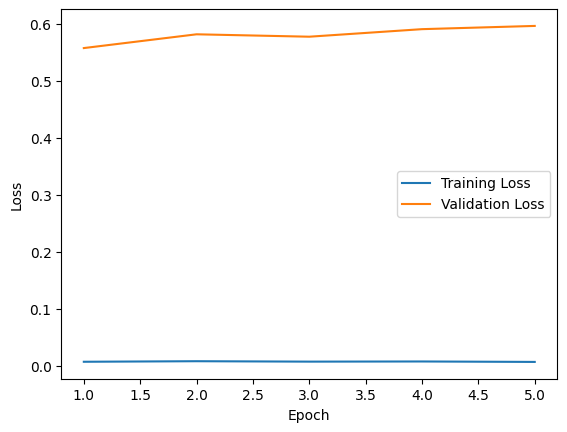

In [49]:
import matplotlib.pyplot as plt
# Graficar el error en entrenamiento y validación por época
epochs_range = np.arange(1, e + 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
train_losses

[0.006937780046975741,
 0.007909825412175988,
 0.007170344552686138,
 0.007452239913325156,
 0.00666170927786058]

In [51]:
val_losses

[0.5578379956158724,
 0.5820221449389602,
 0.577797203352957,
 0.5910547791105328,
 0.596736597292351]

## Resultados 

In [45]:
class TestDataset(Dataset):

    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.texts)
  
    def __getitem__(self, item):
        text = str(self.texts[item])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [46]:
def create_test_data_loader(texts, tokenizer, max_len, batch_size):
    ds = TestDataset(
        texts=texts.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
  )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0 #cambie de 4 a 0 para evitar el posible error otra vez
      )

In [47]:
test_data_loader = create_test_data_loader(
    commentDFVal_clean.text, 
    tokenizer,
    max_secuence_length, 
    batch_size
)

In [48]:
def is_organic(x):
    if(x>=0.5):
        return 1
    else:
        return 0

In [49]:
def get_predictions(model, data_loader):
    
    model = model.eval()
    preds = []
    
    
    with torch.no_grad():
        
        for batch in data_loader:
            
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
        
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            outputs = torch.reshape(outputs, [outputs.shape[0]])
            

            outputs = [(is_organic(x)) for x in outputs]
            outputs = [(preds.append(x)) for x in outputs]
    
#     print(preds)
    return preds

In [50]:
def respuestas(reales, predicciones):
    contador_aciertos = 0
    contador_no_aciertos = 0
    for (real, prediccion) in zip(reales, predicciones):
        if real == prediccion:
            contador_aciertos = contador_aciertos+1
        else:
            contador_no_aciertos = contador_no_aciertos + 1
    return contador_aciertos, contador_no_aciertos  

### 5 epocas

In [55]:
epochs = 5 
train_the_model(epochs)

--------EPOCH SUMMARY---------
Epoch  1  training loss:  0.008469323958120039
Epoch  1  training acc:  56.53174112560928 %
Epoch  1  val acc:  57.29895107673876 %


In [52]:
label_preds = get_predictions(model, test_data_loader)

In [53]:
commentDFVal_clean['beto'] = label_preds

In [54]:
commentDFVal_clean

,text,sentiment,beto
0,Quieres saber lo que los escritores de esta pe...,0,0
1,Esta fue una pelcula muy bien guionadaGran div...,1,1
2,La pelcula no fue tan grandeEl libro es mejorP...,1,1
3,He tenido que cambiar mi opinin sobre la peor ...,0,0
4,El mundo entero est cayendo presa de una enfer...,1,1
...,...,...,...
887,Quin escribi el script para esta pelcula el pe...,0,0
888,Esta es la segunda pelcula que he visto de Ida...,1,1
889,Esta pelcula chupEl primero fue mucho mejorNad...,0,0
890,Me encant esta pelcula lo vi cuando tena unos ...,1,1


In [59]:
fileBETO = "output_BETO"
commentDFVal_clean.to_csv(fileBETO, sep=',', index=False, encoding='utf-8')

In [55]:
print(commentDFVal_clean.beto.value_counts())
print(len(commentDFVal_clean.beto))

1    545
0    347
Name: beto, dtype: int64
892


In [56]:
aciertos, no_aciertos = respuestas(commentDFVal_clean.sentiment, label_preds)

In [57]:
aciertos

744

In [58]:
no_aciertos

148

### 10 epocas 

In [75]:
epochs = 10 
train_the_model(epochs)

/Users/jose/miniforge3/envs/myclone/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


--------EPOCH SUMMARY---------
Epoch  1  training loss:  0.0043877327954897315
Epoch  1  training acc:  78.01643924046589 %
Epoch  1  val acc:  83.62470865249634 %


In [76]:
label_preds = get_predictions(model, test_data_loader)

In [81]:
aciertos, no_aciertos = respuestas(commentDFVal_clean.sentiment, label_preds)

In [82]:
aciertos

748

In [83]:
no_aciertos

144

### 15 epocas

In [ ]:
epochs = 15 
train_the_model(epochs)

In [ ]:
label_preds = get_predictions(model, test_data_loader)

In [ ]:
aciertos, no_aciertos = respuestas(commentDFVal_clean.sentiment, label_preds)